# ***Solving Facebook's Link Prediction using Machine Learning.***

In [85]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import random
import math
from scipy.sparse.linalg import svds, eigs
import networkx as nx
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist 
import seaborn as sns
from tensorflow.keras.initializers import glorot_normal, he_normal
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc

In [19]:
g = nx.read_edgelist('data/after_eda/train_woheader.csv', delimiter = ',', create_using = nx.DiGraph(), nodetype = int)

*1. Number of followers of each person.*

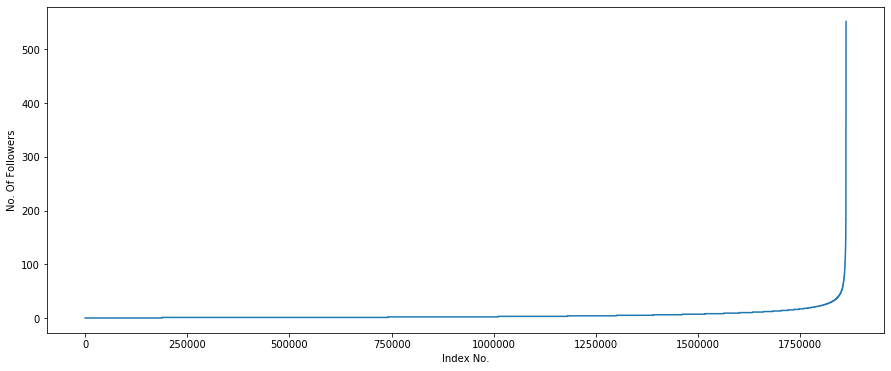

In [8]:
no_of_followers = sorted(list(dict(g.in_degree()).values()))
plt.figure(figsize = (15, 6))
plt.plot(no_of_followers)
plt.xlabel('Index No.')
plt.ylabel('No. Of Followers')
plt.show()

In [9]:
for i in range(90, 101):
    print(i, 'th percentile is:', np.percentile(no_of_followers, i))

90 th percentile is: 12.0
91 th percentile is: 13.0
92 th percentile is: 14.0
93 th percentile is: 15.0
94 th percentile is: 17.0
95 th percentile is: 19.0
96 th percentile is: 21.0
97 th percentile is: 24.0
98 th percentile is: 29.0
99 th percentile is: 40.0
100 th percentile is: 552.0


We can see there is a huge difference between 99th and 100th percentile. Let's zoom in between these percentiles.

In [10]:
for i in np.arange(1, 11)/10:
    print(99 + i, 'th percentile is:', np.percentile(no_of_followers, 99 + i))

99.1 th percentile is: 42.0
99.2 th percentile is: 44.0
99.3 th percentile is: 47.0
99.4 th percentile is: 50.0
99.5 th percentile is: 55.0
99.6 th percentile is: 61.0
99.7 th percentile is: 70.0
99.8 th percentile is: 84.0
99.9 th percentile is: 112.0
100.0 th percentile is: 552.0


We can conclude that 90% of people have upto 40 followers.

*2. Number of people each person is following.*

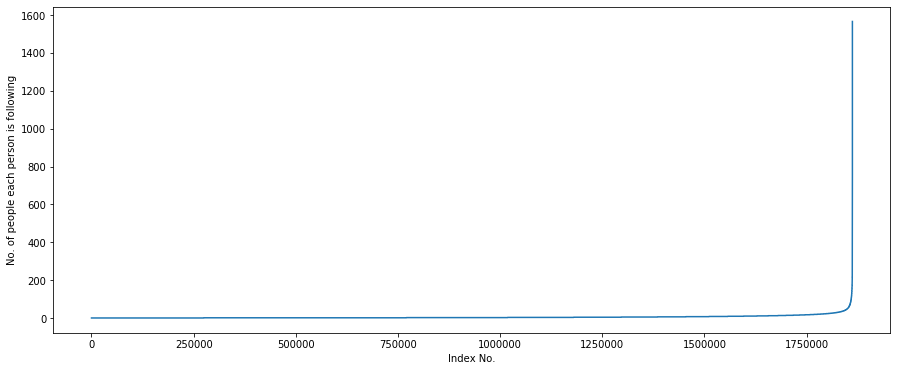

In [11]:
no_of_followees = sorted(list(dict(g.out_degree()).values()))
plt.figure(figsize = (15, 6))
plt.plot(no_of_followees)
plt.xlabel('Index No.')
plt.ylabel('No. of people each person is following')
plt.show()

In [12]:
for i in range(90, 101):
    print(i, 'th percentile is:', np.percentile(no_of_followees, i))

90 th percentile is: 12.0
91 th percentile is: 13.0
92 th percentile is: 14.0
93 th percentile is: 15.0
94 th percentile is: 17.0
95 th percentile is: 19.0
96 th percentile is: 21.0
97 th percentile is: 24.0
98 th percentile is: 29.0
99 th percentile is: 40.0
100 th percentile is: 1566.0


In [13]:
for i in np.arange(1, 11)/10:
    print(99 + i, 'th percentile is:', np.percentile(no_of_followees, 99 + i))

99.1 th percentile is: 42.0
99.2 th percentile is: 45.0
99.3 th percentile is: 48.0
99.4 th percentile is: 52.0
99.5 th percentile is: 56.0
99.6 th percentile is: 63.0
99.7 th percentile is: 73.0
99.8 th percentile is: 90.0
99.9 th percentile is: 123.0
100.0 th percentile is: 1566.0


Percentage of people with 0 followers.

In [14]:
100*(sum(np.array(no_of_followers) == 0) / len(no_of_followers))

10.097786512871734

Percentage of people with 0 followees.

In [15]:
100*(sum(np.array(no_of_followees) == 0) / len(no_of_followees))

14.741115442858524

*Posing a problem as classification problem: Generating some edges which are not present in graph for supervised learning*

In [16]:
len_of_dataset = len(pd.read_csv('data/after_eda/train_woheader.csv', header = None))
total_nodes = len(list(g.nodes))

In [17]:
#'''
r = csv.reader(open('data/after_eda/train_woheader.csv', 'r'))
edges = {}
for edge in r:
    edges[(edge[0], edge[1])] = 1
missing_edges = set()
while (len(missing_edges) < len_of_dataset):
    a = random.randint(1, total_nodes)
    b = random.randint(1, total_nodes)
    temp = edges.get((a,b),-1)
    if temp == -1 and a != b:
        try:
            if nx.shortest_path_length(g, source = a, target = b) > 2:
                missing_edges.add((a, b))
            else:
                continue
        except:
            missing_edges.add((a, b))
    else:
        continue
#'''

In [25]:
df_neg = pd.DataFrame(missing_edges, columns = ['Source', 'Target'])
df_neg['Label'] = 0

In [19]:
df_pos = pd.read_csv('data/after_eda/train_woheader.csv', header = None)
df_pos.columns = ['Source', 'Target']
df_pos['Label'] = 1

In [20]:
df_pos.head()

,Source,Target,Label
0,1,690569,1
1,1,315892,1
2,1,189226,1
3,2,834328,1
4,2,1615927,1


In [26]:
df = pd.concat([df_pos, df_neg], axis = 0)

In [27]:
df.to_csv('df.csv', header = False, index = False)

In [3]:
df_final = pd.read_csv('df.csv', header = None)
df_final.columns = ['Source', 'Target', 'Label']
df_final.head()

,Source,Target,Label
0,1,690569,1
1,1,315892,1
2,1,189226,1
3,2,834328,1
4,2,1615927,1


*Model Featurization*

1. Jaccard Distance : The Jaccard similarity index (sometimes called the Jaccard similarity coefficient) compares members or two sets to see which members are shared and which are distinct. It’s a measure of similarity for the two sets of data, with a range from 0% to 100%. The higher the percentage, the more similar the two populations.

In [4]:
# For followees
def jaccard_for_followees(a, b):
    try:
        if len(set(g.successors(a))) == 0  | len(set(g.successors(b))) == 0:
            return 0
        sim = (len(set(g.successors(a)).intersection(set(g.successors(b)))))/(len(set(g.successors(a)).union(set(g.successors(b)))))
    except:
        return 0
    return sim

In [5]:
df_final['Jaccard_followees'] = df_final.apply(lambda row : jaccard_for_followees(row['Source'], row['Target']), axis = 1)

In [6]:
# For followers
def jaccard_for_followers(a, b):
    try:
        if len(set(g.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(g.predecessors(a)).intersection(set(g.predecessors(b)))))/(len(set(g.predecessors(a)).union(set(g.predecessors(b)))))
        return sim
    except:
        return 0

In [7]:
df_final['Jaccard_followers'] = df_final.apply(lambda row : jaccard_for_followees(row['Source'], row['Target']), axis = 1)

2. Cosine Similarity

In [8]:
# For followees
def cosine_for_followees(a, b):
    try:
        if len(set(g.successors(a))) == 0  | len(set(g.successors(b))) == 0:
            return 0
        sim = (len(set(g.successors(a)).intersection(set(g.successors(b)))))/(math.sqrt(len(set(g.successors(a)))*len((set(g.successors(b))))))
        return sim
    except:
        return 0

In [9]:
df_final['Cosine_followees'] = df_final.apply(lambda row : cosine_for_followees(row['Source'], row['Target']), axis = 1)

In [10]:
# For followers
def cosine_for_followers(a, b):
    try:
        if len(set(g.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(g.predecessors(a)).intersection(set(g.predecessors(b)))))/(math.sqrt(len(set(g.predecessors(a)))*len((set(g.predecessors(b))))))
        return sim
    except:
        return 0

In [11]:
df_final['Cosine_followers'] = df_final.apply(lambda row : cosine_for_followers(row['Source'], row['Target']), axis = 1)

2. Shortest path between 2 nodes.

In [12]:
def compute_shortest_path_length(a, b):
    try:
        if g.has_edge(a, b):
            g.remove_edge(a, b)
            p = nx.shortest_path_length(g, source = a, target = b)
            g.add_edge(a, b)
        else:
            p = nx.shortest_path_length(g, source = a, target = b)
        return p
    except:
        return -1

In [13]:
df_final['Shortest_distance'] = df_final.apply(lambda row : compute_shortest_path_length(row['Source'], row['Target']), axis = 1)

3. Adamic / Adar Index

In [18]:
def calculate_adar_index(a, b):
    s = 0
    try:
        n = list(set(g.successors(a)).intersection(set(g.successors(b))))
        if len(n) != 0:
            for i in n:
                s = s + (1/np.log10(len(list(g.predecessors(i)))))
            return s
        else:
            return 0
    except:
        return 0

In [19]:
df_final['Adar_index'] = df_final.apply(lambda row : calculate_adar_index(row['Source'], row['Target']), axis = 1)

4. Feature representing whether the target node is following back or not?

In [22]:
def follows_back(a, b):
    if g.has_edge(b, a):
        return 1
    else:
        return 0

In [23]:
df_final['Follows back'] = df_final.apply(lambda row : follows_back(row['Source'], row['Target']), axis = 1)

5. Adding features which depend on the number of followers and followees.

In [ ]:
num_followers_s = []
num_followees_s = []
num_followers_d = []
num_followees_d = []
inter_followers = []
inter_followees = []

for i, row in df_final.iterrows():
    try:
        s1 = set(g.predecessors(row['Source']))
        s2 = set(g.successors(row['Source']))
    except:
        s1 = set()
        s2 = set()
    try:
        d1 = set(g.predecessors(row['Target']))
        d2 = set(g.successors(row['Target']))
    except:
        d1 = set()
        d2 = set()
    num_followers_s.append(len(s1))
    num_followees_s.append(len(s2))
    num_followers_d.append(len(d1))
    num_followees_d.append(len(d2))
    inter_followers.append(len(s1.intersection(d1)))
    inter_followees.append(len(s2.intersection(d2)))

df_final['num_followers_s'] = num_followers_s
df_final['num_followees_s'] = num_followees_s
df_final['num_followers_d'] = num_followers_d
df_final['num_followees_d'] = num_followees_d
df_final['inter_followers'] = inter_followers
df_final['inter_followees'] = inter_followees

7. Weight Features:
In order to determine the similarity of nodes an edge weight value can be calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 

Credit: Graph - based Features for Supervised Link Prediction William Cukierski, Benjamin Hamner, Bo Yang.

𝑊 = 1/(sqrt(1 + |X|))

In case we don't get any values for any node, we will use the median value for imputation.

In [12]:
graph = g.nodes
Weight_in = {}
Weight_out = {}
for i in  graph:
    s1 = set(g.predecessors(i))
    Weight_in[i] = 1.0/(np.sqrt(1 + len(s1)))
    s2 = set(g.successors(i))
    Weight_out[i] = 1.0/(np.sqrt(1 + len(s2)))
    
mean_weight_in = np.median(list(Weight_in.values()))
mean_weight_out = np.median(list(Weight_out.values()))

df_final['weight_in'] = df_final['Target'].apply(lambda x : Weight_in.get(x, mean_weight_in))
df_final['weight_out'] = df_final['Source'].apply(lambda x : Weight_out.get(x, mean_weight_out))

# Adding additional ratio feature 
df_final['weight_ratio'] = df_final['weight_in']/df_final['weight_out']

Since, after feature engineering, we have a huge dataset (more than 2 GB), so from here I have decided to choose only a 100,000 rows only.

In [2]:
skiprows = random.sample(list(range(0, 18875036)), 18775036)

In [14]:
df_final_sample = pd.read_csv('df.csv', skiprows = skiprows)
df_final_sample.columns = ['Source', 'Target', 'Label', 'Jaccard_followees', 'Jaccard_followers',
                           'Cosine_followees', 'Cosine_followers', 'Shortest_distance',
                           'Weakly connected', 'Adar_index', 'Follows back', 'num_followers_s',
                           'num_followees_s', 'num_followers_d', 'num_followees_d',
                           'inter_followers', 'inter_followees', 'weight_in', 'weight_out',
                           'weight_ratio', 'prefrential_attachment_followees',
                           'prefrential_attachment_followers']
df_final_sample.head()

,Source,Target,Label,Jaccard_followees,Jaccard_followers,Cosine_followees,Cosine_followers,Shortest_distance,Weakly connected,Adar_index,...,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees,weight_in,weight_out,weight_ratio,prefrential_attachment_followees,prefrential_attachment_followers
0,119,875039,1,0.277778,0.277778,0.435194,0.400000,2,0.0,4.975204,...,11,15,12,6,5,0.250000,0.288675,0.866025,0,0
1,133,1210717,1,0.000000,0.000000,0.000000,0.000000,6,0.0,0.000000,...,7,12,8,0,0,0.277350,0.353553,0.784465,0,0
2,171,1131806,1,0.019802,0.019802,0.040242,0.019676,2,0.0,1.070989,...,38,63,65,1,2,0.125000,0.160128,0.780625,0,0
3,172,1556441,1,0.047619,0.047619,0.158114,0.147442,2,0.0,3.321928,...,20,2,2,1,1,0.577350,0.218218,2.645751,0,0
4,179,232801,1,0.225806,0.225806,0.368421,0.317554,2,0.0,6.305179,...,19,21,19,6,7,0.213201,0.223607,0.953463,0,0


In [37]:
df_final = pd.read_csv('df_sample.csv')
df_final.columns

Index(['Source', 'Target', 'Label', 'Jaccard_followees', 'Jaccard_followers',
       'Cosine_followees', 'Cosine_followers', 'Shortest_distance',
       'Weakly connected', 'Adar_index', 'Follows back', 'num_followers_s',
       'num_followees_s', 'num_followers_d', 'num_followees_d',
       'inter_followers', 'inter_followees', 'weight_in', 'weight_out',
       'weight_ratio', 'prefrential_attachment_followees',
       'prefrential_attachment_followers'],
      dtype='object')

8. SVD features for both Source and Target.

In [20]:
sadj_col = sorted(g.nodes())
sadj_dict = {val : idx for idx, val in enumerate(sadj_col)}

In [21]:
def svd(x, U):
    try:
        z = sadj_dict[x]
        return U[z]
    except:
        return [0, 0, 0, 0, 0, 0]

In [22]:
Adj = nx.adjacency_matrix(g, nodelist = sadj_col).asfptype()

In [23]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape', Adj.shape)
print('U Shape', U.shape)
print('V Shape', V.shape)
print('s Shape', s.shape)

Adjacency matrix Shape (1862220, 1862220)
U Shape (1862220, 6)
V Shape (6, 1862220)
s Shape (6,)


In [38]:
df_final[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = df_final['Source'].apply(lambda x : svd(x, U)).apply(pd.Series)

In [39]:
df_final[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = df_final['Target'].apply(lambda x: svd(x, U)).apply(pd.Series)

In [40]:
df_final[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']] = df_final['Source'].apply(lambda x: svd(x, V.T)).apply(pd.Series)

In [41]:
df_final[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = df_final['Target'].apply(lambda x: svd(x, V.T)).apply(pd.Series)

9. Prefrential Attachment

In [25]:
def prefrential_attachment_followees(a, b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = len(set(train_graph.successors(a)))*len(set(train_graph.successors(b)))
        return sim
    except:
        return 0
    
def prefrential_attachment_followers(a, b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = len(set(train_graph.predecessors(a)))*len(set(train_graph.predecessors(b)))
        return sim
    except:
        return 0

In [26]:
df_final['prefrential_attachment_followees'] = df_final.apply(lambda row : prefrential_attachment_followees(row['Source'], row['Target']), axis = 1)
df_final['prefrential_attachment_followers'] = df_final.apply(lambda row : prefrential_attachment_followers(row['Source'], row['Target']), axis = 1)

10. Dot product of SVD features

In [42]:
train_svd_s = df_final[['svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']]
train_svd_d = df_final[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6']]

In [43]:
svd_dot_train = []
for i in range(len(train_svd_s)):
    svd_dot_train.append(sum(train_svd_s.values[i]*train_svd_d.values[i]))

In [44]:
df_final['svd_dot'] = svd_dot_train

Finally saving the sampled data into a csv file with name 'df_sample'.

In [48]:
df_final.to_csv('df_sample.csv', index = False)

In [53]:
df_final = pd.read_csv('df_sample.csv')
df_final.head()

,Source,Target,Label,Jaccard_followees,Jaccard_followers,Cosine_followees,Cosine_followers,Shortest_distance,Weakly connected,Adar_index,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot
0,119,875039,1,0.277778,0.277778,0.435194,0.400000,2,0.0,4.975204,...,1.713615e-12,-4.108550e-12,-1.518989e-14,-1.645059e-12,3.033147e-12,3.488969e-10,1.673758e-12,-4.683631e-12,-1.422430e-14,2.649979e-20
1,133,1210717,1,0.000000,0.000000,0.000000,0.000000,6,0.0,0.000000,...,7.550085e-16,-1.213776e-15,-3.133035e-17,-1.409895e-13,4.182263e-12,1.363031e-09,1.573085e-13,-1.320560e-13,-2.291823e-14,1.256458e-21
2,171,1131806,1,0.019802,0.019802,0.040242,0.019676,2,0.0,1.070989,...,6.612150e-12,-1.605865e-10,-1.261696e-12,-3.262227e-11,2.091583e-11,6.073744e-05,7.004577e-12,-2.047030e-10,-1.954556e-12,2.615217e-09
3,172,1556441,1,0.047619,0.047619,0.158114,0.147442,2,0.0,3.321928,...,8.015757e-13,-3.009462e-12,-2.571068e-14,-1.082002e-13,2.957343e-13,1.138975e-11,1.551174e-15,-3.601165e-14,-6.286877e-17,4.150097e-21
4,179,232801,1,0.225806,0.225806,0.368421,0.317554,2,0.0,6.305179,...,6.488662e-13,-5.387808e-12,-9.573928e-15,-1.351383e-12,5.299936e-12,2.597988e-11,1.882403e-13,-6.083864e-13,-2.888575e-14,3.270107e-20


In [55]:
columns = df_final.drop('Label', axis = 1).columns
columns

Index(['Source', 'Target', 'Jaccard_followees', 'Jaccard_followers',
       'Cosine_followees', 'Cosine_followers', 'Shortest_distance',
       'Weakly connected', 'Adar_index', 'Follows back', 'num_followers_s',
       'num_followees_s', 'num_followers_d', 'num_followees_d',
       'inter_followers', 'inter_followees', 'weight_in', 'weight_out',
       'weight_ratio', 'prefrential_attachment_followees',
       'prefrential_attachment_followers', 'svd_u_s_1', 'svd_u_s_2',
       'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1',
       'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6',
       'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5',
       'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4',
       'svd_v_d_5', 'svd_v_d_6', 'svd_dot'],
      dtype='object')

In [64]:
X = df_final.drop('Label', axis = 1).values
y = df_final['Label'].values

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## ***Model Training***

In [74]:
import lightgbm as LGB
clf = LGB.LGBMClassifier(n_jobs = -1)
parameters = {"n_estimators" : sp_randint(105, 125),
              "max_depth" : sp_randint(10, 15),
              "min_samples_split" : sp_randint(110, 190),
              "min_samples_leaf" : sp_randint(25, 65)}

model = RandomizedSearchCV(clf, parameters, cv = 3, scoring = 'f1', return_train_score = True)
model.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning]

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002787DD31188>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000278827FD348>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000027882483F48>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002787E83E2C8>},
                   return_train_score=True, scoring='f1')

In [75]:
model.best_params_

{'max_depth': 14,
 'min_samples_leaf': 62,
 'min_samples_split': 121,
 'n_estimators': 119}

In [76]:
model.best_score_

0.9748060378726707

In [77]:
clf = LGB.LGBMClassifier(n_estimators = 119, max_depth = 14, min_samples_leaf = 62, min_samples_split = 121, n_jobs = -1)
clf.fit(X_train, y_train)

LGBMClassifier(max_depth=14, min_samples_leaf=62, min_samples_split=121,
               n_estimators=119)

In [78]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [81]:
print('Train confusion_matrix')
print(confusion_matrix(y_train, y_train_pred))
print('Test confusion_matrix')
print(confusion_matrix(y_test, y_test_pred))

Train confusion_matrix
[[34828   203]
 [  942 34028]]
Test confusion_matrix
[[14718   162]
 [  510 14611]]


In [83]:
print('Train f1 score', f1_score(y_train, y_train_pred))
print('Test f1 score', f1_score(y_test, y_test_pred))

Train f1 score 0.9834539963295328
Test f1 score 0.977520572690172


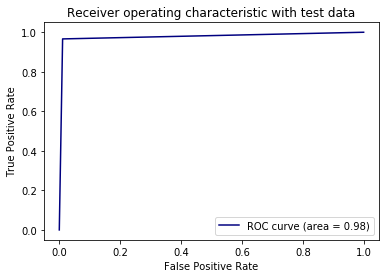

In [84]:
fpr, tpr, ths = roc_curve(y_test, y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy', label = 'ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

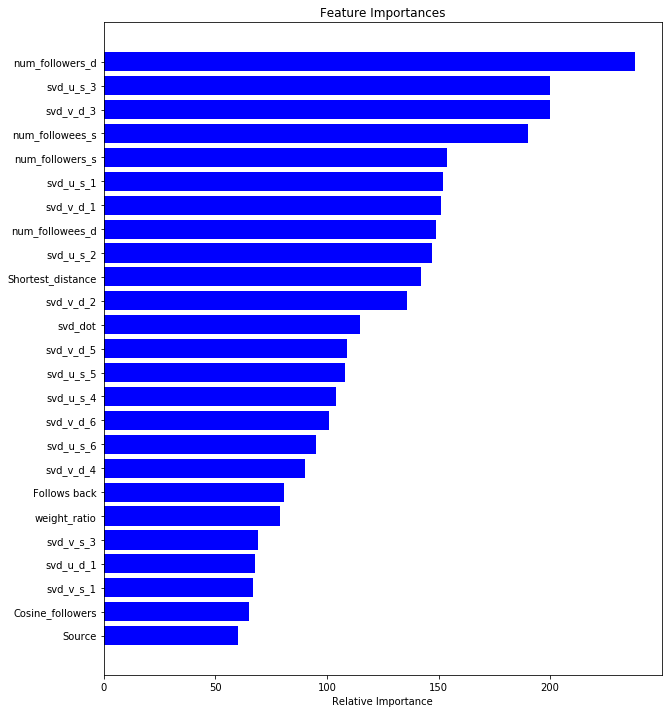

In [88]:
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize = (10, 12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color = 'blue', align = 'center')
plt.yticks(range(len(indices)), [columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()